In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
import glob
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

Uma estratégia utilizada para reduzir o dataset original foi pegar apenas uma a cada 5 imagens. Isso ocorre porque estamos lidando com frames de vídeos e dois frames consecutivos são extremamente parecidos entre si. O diretório asl_filtered tem, então, 20% do tamanho do diretório original.

In [11]:
source_dir = "asl_alphabet_train/asl_alphabet_train"
target_dir = "asl_filtered"

os.makedirs(target_dir, exist_ok=True)

for label in os.listdir(source_dir):
    source_label_dir = os.path.join(source_dir, label)
    target_label_dir = os.path.join(target_dir, label)
    os.makedirs(target_label_dir, exist_ok=True)

    files = sorted(os.listdir(source_label_dir))

    selected_files = [f for i, f in enumerate(files) if i % 5 == 0]

    for file in selected_files:
        src_path = os.path.join(source_label_dir, file)
        dst_path = os.path.join(target_label_dir, file)
        shutil.copy2(src_path, dst_path) 

In [20]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
list_path = []
list_labels = []
TRAIN_PATH = "asl_filtered"


for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,asl_filtered\A\A1.jpg,A
1,asl_filtered\A\A1002.jpg,A
2,asl_filtered\A\A1007.jpg,A
3,asl_filtered\A\A1011.jpg,A
4,asl_filtered\A\A1016.jpg,A
...,...,...
15595,asl_filtered\Z\Z977.jpg,Z
15596,asl_filtered\Z\Z981.jpg,Z
15597,asl_filtered\Z\Z986.jpg,Z
15598,asl_filtered\Z\Z990.jpg,Z


In [41]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=0.3,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)

# Create Final DataFrames
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})

In [42]:
label_to_index = {chr(ord('A') + i): i for i in range(26)}  # {'A': 0, 'B': 1, ..., 'Z': 25}

# Apply to your dataframes
data_train['label'] = data_train['label'].map(label_to_index)
data_val['label'] = data_val['label'].map(label_to_index)

In [43]:
data_val.head(10)

,image_path,label
6828,asl_filtered\L\L2024.jpg,11
9945,asl_filtered\Q\Q2551.jpg,16
5062,asl_filtered\I\I2178.jpg,8
15162,asl_filtered\Z\Z1728.jpg,25
11623,asl_filtered\T\T2001.jpg,19
8726,asl_filtered\O\O2466.jpg,14
4628,asl_filtered\H\H2925.jpg,7
8551,asl_filtered\O\O1679.jpg,14
4822,asl_filtered\I\I1098.jpg,8
5709,asl_filtered\J\J239.jpg,9


In [44]:
data_train.head(10)

,image_path,label
7413,asl_filtered\M\M1958.jpg,12
5892,asl_filtered\J\J512.jpg,9
10184,asl_filtered\Q\Q927.jpg,16
10731,asl_filtered\R\R689.jpg,17
2891,asl_filtered\E\E508.jpg,4
352,asl_filtered\A\A2583.jpg,0
3736,asl_filtered\G\G1610.jpg,6
240,asl_filtered\A\A2079.jpg,0
14908,asl_filtered\Y\Y585.jpg,24
3456,asl_filtered\F\F350.jpg,5


In [47]:
train_ds = tf.data.Dataset.from_tensor_slices((data_train['image_path'].values, data_train['label'].values))
val_ds = tf.data.Dataset.from_tensor_slices((data_val['image_path'].values, data_val['label'].values))

In [48]:
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = (200, 200)

def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    return image, label

In [49]:
BATCH_SIZE = 32
train_ds = train_ds.map(process_image)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE)
val_ds = val_ds.map(process_image)
val_ds = val_ds.batch(BATCH_SIZE)

In [50]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [51]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

num_classes = data_train['label'].nunique()

base_model = EfficientNetB0(include_top=False, input_shape=(200, 200, 3), weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
342/342 [==============================] - 30s 77ms/step - loss: 2.2177 - accuracy: 0.7675 - val_loss: 1.3140 - val_accuracy: 0.8735
Epoch 2/10
342/342 [==============================] - 23s 67ms/step - loss: 0.6996 - accuracy: 0.9206 - val_loss: 0.7210 - val_accuracy: 0.9267
Epoch 3/10
342/342 [==============================] - 23s 67ms/step - loss: 0.4560 - accuracy: 0.9482 - val_loss: 0.4079 - val_accuracy: 0.9594
Epoch 4/10
342/342 [==============================] - 24s 69ms/step - loss: 0.4588 - accuracy: 0.9527 - val_loss: 0.4300 - val_accuracy: 0.9632
Epoch 5/10
342/342 [==============================] - 23s 67ms/step - loss: 0.4549 - accuracy: 0.9580 - val_loss: 0.7733 - val_accuracy: 0.9444
Epoch 6/10
342/342 [==============================] - 24s 69ms/step - loss: 0.3645 - accuracy: 0.9684 - val_loss: 0.5833 - val_accuracy: 0.9596
Epoch 7/10
342/342 [==============================] - 24s 69ms/step - loss: 0.4057 - accuracy: 0.9702 - val_loss: 0.4388 - val_accuracy:

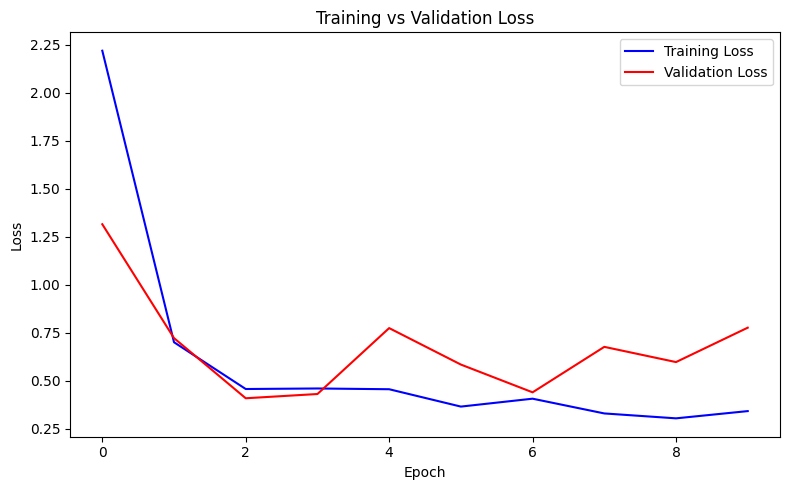

In [53]:
epochs = np.arange(10)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

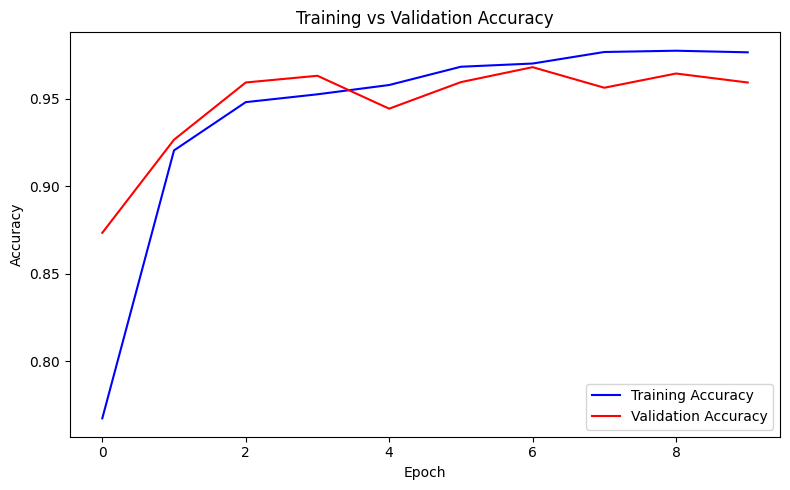

In [54]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
model.save('models/b0/b0_model.keras')

C:\Users\User\anaconda3\envs\gpu_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [55]:
from tensorflow.keras.applications import EfficientNetB7

base_model = EfficientNetB7(include_top=False, input_shape=(200, 200, 3), weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
342/342 [==============================] - 149s 399ms/step - loss: 4.3310 - accuracy: 0.7339 - val_loss: 1.1735 - val_accuracy: 0.9030
Epoch 2/10
342/342 [==============================] - 132s 384ms/step - loss: 1.4519 - accuracy: 0.9016 - val_loss: 1.0719 - val_accuracy: 0.9271
Epoch 3/10
342/342 [==============================] - 141s 411ms/step - loss: 1.2874 - accuracy: 0.9232 - val_loss: 1.4667 - val_accuracy: 0.9194
Epoch 4/10
342/342 [==============================] - 131s 384ms/step - loss: 1.1675 - accuracy: 0.9306 - val_loss: 1.4400 - val_accuracy: 0.9338
Epoch 5/10
342/342 [==============================] - 144s 420ms/step - loss: 1.2155 - accuracy: 0.9434 - val_loss: 1.2067 - val_accuracy: 0.9470
Epoch 6/10
342/342 [==============================] - 131s 384ms/step - loss: 1.1083 - accuracy: 0.9480 - val_loss: 0.8964 - val_accuracy: 0.9603
Epoch 7/10
342/342 [==============================] - 131s 384ms/step - loss: 0.9539 - accuracy: 0.9553 - val_loss: 0.6981 -

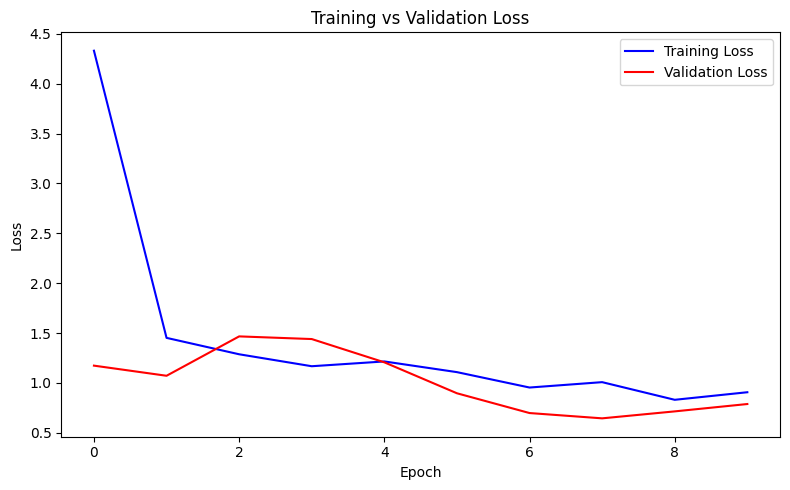

In [57]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

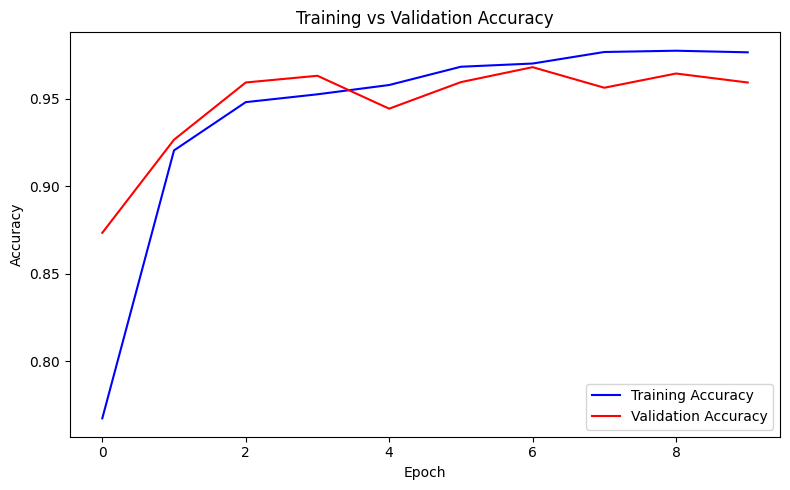

In [58]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
model.save('models/b7/b7_model.keras')

C:\Users\User\anaconda3\envs\gpu_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
